<a href="https://colab.research.google.com/github/NatBrian/mediapipe-hand-recognition/blob/brian/notebooks/keypoint_training_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keypoint Classification – Classical ML Baselines

## 1. Project Overview

In this notebook, we are comparing several **classical machine learning algorithms** for hand gesture recognition.

Each sample in the dataset corresponds to a single hand gesture, represented by:

- **21 hand landmarks** extracted using **MediaPipe Hands**,
- Each landmark providing 2D coordinates → 21 × 2 = 42 numeric features,
- A **gesture label** (integer class) in the first column.

In [69]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime
import os

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
sns.set_theme(style="whitegrid")


## 2. Algorithm Selection via the Scikit-learn Machine Learning Map

We now justify the choice of algorithms using the [scikit-learn machine learning map](https://scikit-learn.org/stable/machine_learning_map.html) (“Choosing the right estimator”).

Following the decision flow:

1. **">50 samples?" → YES**  
   Our dataset contains over one thousand samples, so we have enough data for classical methods.

2. **"Predicting a category?" → YES**  
   Hand gesture recognition is a **classification** problem: each input belongs to one of several discrete gesture classes (0, 1, 2, …).

3. **"Do you have labeled data?" → YES**  
   The CSV dataset includes labels in the first column, so this is a **supervised learning** setting.

4. **"<100K samples?" → YES**  
   The total number of samples is well below 100,000, so we follow the branch for medium-sized datasets.

5. **"Text data?" → NO**  
   Our features are numeric coordinates (landmarks), not text.

Along this branch, the cheat sheet suggests the following families of algorithms:

- **Linear models**:  
  - Linear SVC (linear Support Vector Machine).  
  - Logistic Regression (not always drawn explicitly but conceptually on the same level).

- **Non-linear models and neighbors**:  
  - KNeighbors Classifier (k-Nearest Neighbors).  
  - SVC with non-linear kernels (typically RBF).

- **Ensembles**:  
  - Random Forests and other tree-based ensembles.

These algorithms are all well-suited to numeric tabular data with tens of features and a few thousand samples, which matches our Mediapipe keypoint setting.

In this notebook, we will therefore compare:

1. **Linear SVC**
2. **Logistic Regression**
3. **KNeighbors Classifier**
4. **SVC (RBF kernel)**
5. **Random Forest Classifier**


## 3. Dataset Loading and Basic Understanding

Dataset collected via your Mediapipe + logging script and stored as a CSV file `keypoint.csv`, with:

- Column 0: integer class label (gesture id),
- Columns 1–42: 42 numeric features (flattened x, y coordinates for 21 landmarks).


In [70]:
# Path to the keypoint dataset CSV file
DATA_PATH = "../data/keypoint.csv"

# Load the entire CSV (label + 42 features)
data = np.loadtxt(
    DATA_PATH,
    delimiter=',',
    dtype=np.float32
)

print("Raw dataframe shape:", data.shape)


Raw dataframe shape: (1267, 43)


### 3.1 Interpreting the Data

From the shape:

- Number of samples (rows): `N`
- Number of columns: 43
  - 1 label column + 42 feature columns

We now split the DataFrame into:

- `X`: feature matrix of shape `(N, 42)`
- `y`: label vector of shape `(N,)`

For clarity in the report, we can map labels to gesture names.
Example (adjust to your dataset):

- 0:	Open Hand / Palm
- 1:	Closed Fist
- 2:	Pointing (Index Point)
- 3:	OK Sign
- 4:	Peace / Victory ✌️
- 5:	Rock / Metal 🤘


In [71]:
NUM_LANDMARKS = 21
FEATURES_PER_LANDMARK = 2
INPUT_DIM = NUM_LANDMARKS * FEATURES_PER_LANDMARK

# Verify column count
assert data.shape[1] == 1 + INPUT_DIM, "Expected 1 label + 42 features."

# Load features (columns 1..42)
X_dataset = np.loadtxt(
    DATA_PATH,
    delimiter=',',
    dtype='float32',
    usecols=list(range(1, INPUT_DIM + 1))
)

# Load labels (column 0)
y_dataset = np.loadtxt(
    DATA_PATH,
    delimiter=',',
    dtype='int32',
    usecols=(0,)
)

print("X shape (features):", X_dataset.shape)
print("y shape (labels):", y_dataset.shape)

# Number of gesture labels
unique_labels, counts = np.unique(y_dataset, return_counts=True)
num_classes = len(unique_labels)



X shape (features): (1267, 42)
y shape (labels): (1267,)


Label distribution:
Class 0: 200 samples
Class 1: 190 samples
Class 2: 204 samples
Class 3: 213 samples
Class 4: 239 samples
Class 5: 221 samples


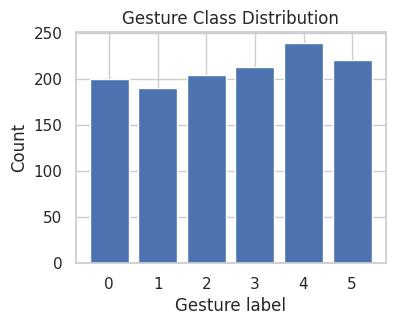

In [72]:
# Compute unique labels and counts using NumPy
labels, counts = np.unique(y_dataset, return_counts=True)

print("Label distribution:")
for label, count in zip(labels, counts):
    print(f"Class {label}: {count} samples")

# Simple bar plot of label distribution
plt.figure(figsize=(4, 3))
plt.bar(labels, counts)
plt.xticks(labels)
plt.xlabel("Gesture label")
plt.ylabel("Count")
plt.title("Gesture Class Distribution")
plt.show()


### 3.2 Visualising a Hand Sample

To confirm that our features indeed represent 2D hand landmarks, we can reshape a single sample into `(21, 2)` and plot the points. This is mainly for sanity-checking the data format.


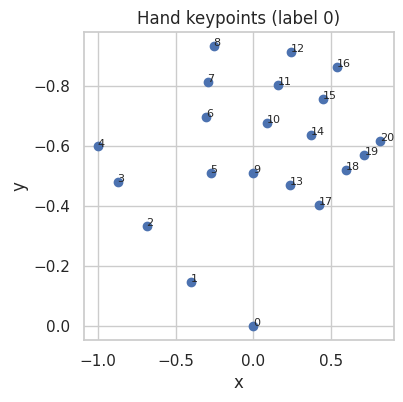

In [73]:
def plot_hand_keypoints(sample, title="Example hand keypoints"):
    """
    sample: numpy array of shape (42,) with [x1, y1, x2, y2, ..., x21, y21]
    """
    assert sample.shape == (INPUT_DIM,)

    points = sample.reshape(NUM_LANDMARKS, FEATURES_PER_LANDMARK)
    xs = points[:, 0]
    ys = points[:, 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(xs, ys)
    # Optionally connect points in some fixed order (not critical for this project)
    for i, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, str(i), fontsize=8)
    plt.gca().invert_yaxis()  # often needed depending on coordinate system
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Plot first sample
plot_hand_keypoints(X_dataset[0], title=f"Hand keypoints (label {y_dataset[0]})")

## 4. Train/Test Split and Evaluation Setup

We now split the dataset into **training** and **test** sets:

- Training set: used to fit the models.
- Test set: held out for final evaluation only.

We use a stratified split so that all gesture classes are represented in both splits proportionally.


In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset,
    y_dataset,
    train_size=0.75,
    random_state=RANDOM_SEED,
    stratify=y_dataset  # keep class proportions similar
)

print("Training set shape:", X_train.shape)
print("Train set size:", X_train.shape[0])
print("Test set shape:", X_test.shape)
print("Test set size:", X_test.shape[0])

Training set shape: (950, 42)
Train set size: 950
Test set shape: (317, 42)
Test set size: 317


## 5. Classical ML Models for Gesture Classification

We define five models corresponding to the algorithms selected from the scikit-learn flowchart:

1. **Linear SVC** – linear Support Vector Machine baseline.  
2. **Logistic Regression** – linear probabilistic classifier (softmax) on the same level as Linear SVC.  
3. **KNeighbors Classifier** – instance-based method that classifies by nearest examples in keypoint space.  
4. **SVC (RBF kernel)** – non-linear SVM capable of modeling curved decision boundaries between gestures.  
5. **Random Forest (Ensemble)** – collection of decision trees that captures non-linear relationships between landmarks.


### Why StandardScaler is Included

For the first four algorithms, we include a **StandardScaler** inside a scikit-learn `Pipeline`. Standardization transforms each feature so that it has:

- mean = 0  
- standard deviation = 1  

This step is important for the following reasons:

- **SVM-based models (Linear SVC and SVC RBF)** are sensitive to the relative scale of features.  
  Unscaled landmark coordinates can cause the optimization process to behave poorly or converge to suboptimal solutions because features with larger numeric ranges dominate the decision boundary.

- **Logistic Regression** relies on gradient-based optimization.  
  Scaling helps the optimizer converge more quickly and leads to more stable and reliable model training.

- **KNeighbors Classifier** computes distances between samples.  
  Without scaling, features with larger numeric ranges disproportionately influence distance calculations, leading to incorrect neighbor relationships.

In contrast, **Random Forest** is based on decision trees, which split on feature thresholds and are therefore **not sensitive to feature scaling**. For this reason, a scaler is not necessary for tree-based ensembles.

Using a `Pipeline` ensures that the same scaling is automatically applied during both training and inference, preventing inconsistencies between your offline model training and your real-time Mediapipe pipeline.


In [75]:
models = {
    "LinearSVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(
            C=1.0,
            loss="squared_hinge",
            random_state=RANDOM_SEED,
            dual=False  # recommended when n_samples > n_features
        )),
    ]),

    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=1000,
            random_state=RANDOM_SEED,
        )),
    ]),

    "KNeighbors": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(
            n_neighbors=5,
            weights="distance",
            metric="minkowski",
        )),
    ]),

    "SVC_RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(
            kernel="rbf",
            C=10.0,
            gamma="scale",
            probability=True,  # enables predict_proba if needed
            random_state=RANDOM_SEED,
        )),
    ]),

    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
}

print("Defined models:", list(models.keys()))


Defined models: ['LinearSVC', 'LogisticRegression', 'KNeighbors', 'SVC_RBF', 'RandomForest']


### 5.1 Training, Evaluating, and Saving Each Model

For each model, we:

1. Fit on the training set.
2. Predict labels on the test set.
3. Compute:
   - Accuracy on the test set,
   - Macro-averaged F1-score (treats all classes equally),
   - Weighted F1-score (weights by class frequency).
4. Store the confusion matrix and text classification report.
5. Save the trained model to disk using `joblib.dump`.

These saved model files can later be loaded inside your real-time Mediapipe pipeline using `joblib.load`.


In [76]:
metrics = {}
conf_matrices = {}
reports = {}

for name, model in models.items():
    print("=" * 80)
    print(f"Training model: {name}")
    print("=" * 80)

    start_time = datetime.datetime.now()
    model.fit(X_train, y_train)
    end_time = datetime.datetime.now()

    train_time = (end_time - start_time).total_seconds()
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report_dict = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        zero_division=0
    )

    f1_macro = report_dict["macro avg"]["f1-score"]
    f1_weighted = report_dict["weighted avg"]["f1-score"]

    # Store numeric metrics
    metrics[name] = {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "train_time_sec": train_time,
    }

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    conf_matrices[name] = cm

    # Full text report (for later display)
    reports[name] = classification_report(
        y_test,
        y_pred,
        digits=3,
        zero_division=0
    )

    # Save model
    filename = f"../models/keypoint/keypoint_classifier_{name}_{timestamp}.joblib"
    joblib.dump(model, filename)

    print(f"\nTest accuracy for {name}: {acc:.4f}")
    print(f"Macro F1-score for {name}: {f1_macro:.4f}")
    print(f"Weighted F1-score for {name}: {f1_weighted:.4f}")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Saved trained model to: {filename}")


Training model: LinearSVC

Test accuracy for LinearSVC: 0.8517
Macro F1-score for LinearSVC: 0.8510
Weighted F1-score for LinearSVC: 0.8521
Training time: 0.06 seconds
Saved trained model to: models/keypoint/keypoint_classifier_LinearSVC_20251119_095007.joblib
Training model: LogisticRegression

Test accuracy for LogisticRegression: 0.8644
Macro F1-score for LogisticRegression: 0.8637
Weighted F1-score for LogisticRegression: 0.8639
Training time: 0.09 seconds
Saved trained model to: models/keypoint/keypoint_classifier_LogisticRegression_20251119_095007.joblib
Training model: KNeighbors

Test accuracy for KNeighbors: 0.9432
Macro F1-score for KNeighbors: 0.9441
Weighted F1-score for KNeighbors: 0.9437
Training time: 0.00 seconds
Saved trained model to: models/keypoint/keypoint_classifier_KNeighbors_20251119_095007.joblib
Training model: SVC_RBF


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Test accuracy for SVC_RBF: 0.9842
Macro F1-score for SVC_RBF: 0.9832
Weighted F1-score for SVC_RBF: 0.9843
Training time: 0.20 seconds
Saved trained model to: models/keypoint/keypoint_classifier_SVC_RBF_20251119_095007.joblib
Training model: RandomForest

Test accuracy for RandomForest: 0.9558
Macro F1-score for RandomForest: 0.9565
Weighted F1-score for RandomForest: 0.9561
Training time: 2.45 seconds
Saved trained model to: models/keypoint/keypoint_classifier_RandomForest_20251119_095007.joblib


## 6. Comparing the Algorithms

We now summarise the performance of all models in a single table and visualise the comparison using simple plots.

We will compare:

- Test accuracy,
- Macro F1-score,
- Weighted F1-score,
- Training time (seconds).


In [77]:
results_df = pd.DataFrame(metrics).T
results_df = results_df.sort_values(by="accuracy", ascending=False)

print("Aggregated results (sorted by accuracy):")
results_df


Aggregated results (sorted by accuracy):


,accuracy,f1_macro,f1_weighted,train_time_sec
SVC_RBF,0.984227,0.983238,0.984258,0.195418
RandomForest,0.955836,0.956457,0.956074,2.449397
KNeighbors,0.943218,0.944148,0.943660,0.003392
LogisticRegression,0.864353,0.863706,0.863932,0.086621
LinearSVC,0.851735,0.851008,0.852116,0.057827


### 6.1 Bar Plots: Accuracy and F1-scores

We visualise the test accuracy and macro F1-score for each model to get an immediate sense of which algorithms perform best on this task.


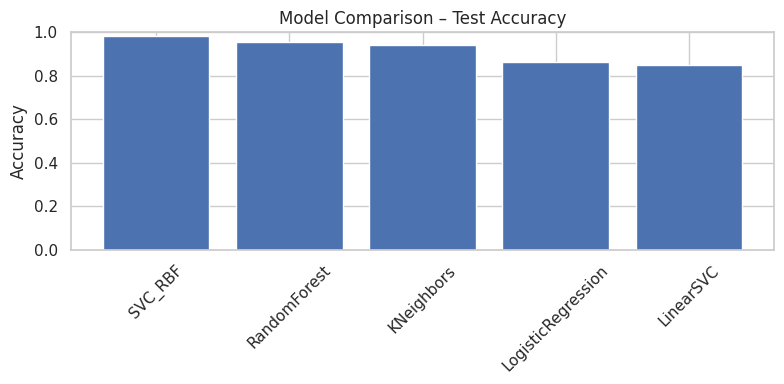

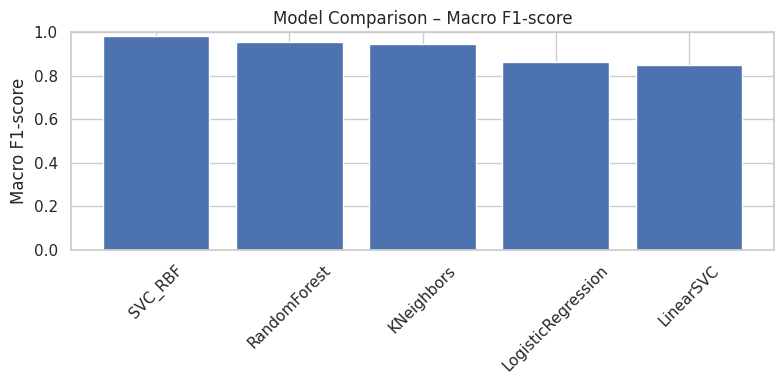

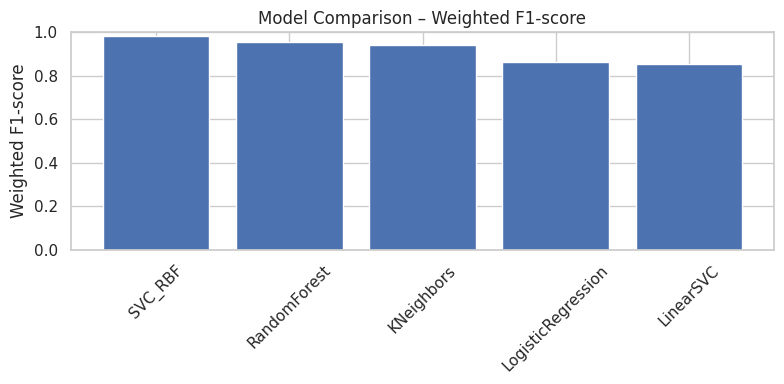

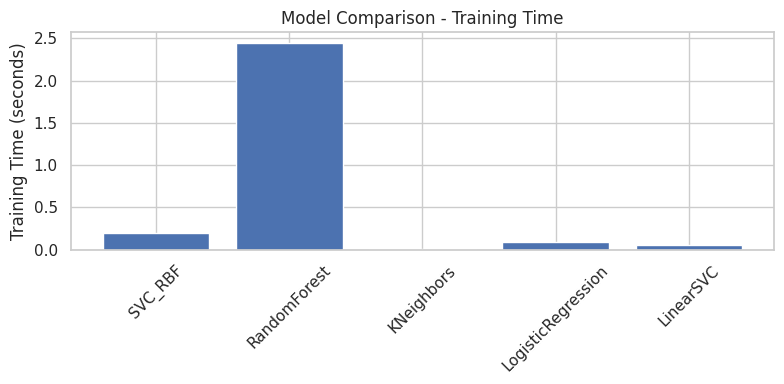

In [78]:
plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["accuracy"])
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Comparison – Test Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["f1_macro"])
plt.ylim(0, 1.0)
plt.ylabel("Macro F1-score")
plt.title("Model Comparison – Macro F1-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["f1_weighted"])
plt.ylim(0, 1.0)
plt.ylabel("Weighted F1-score")
plt.title("Model Comparison – Weighted F1-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["train_time_sec"])
plt.ylabel("Training Time (seconds)")
plt.title("Model Comparison - Training Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### 6.2 Confusion Matrix and Classification Report for the Best Model

We now inspect the **best model** (by accuracy) in more detail using:

- A confusion matrix, showing how often each true class is classified into each predicted class.
- The full classification report, including precision, recall, and F1-score per class.


Best model by accuracy: SVC_RBF


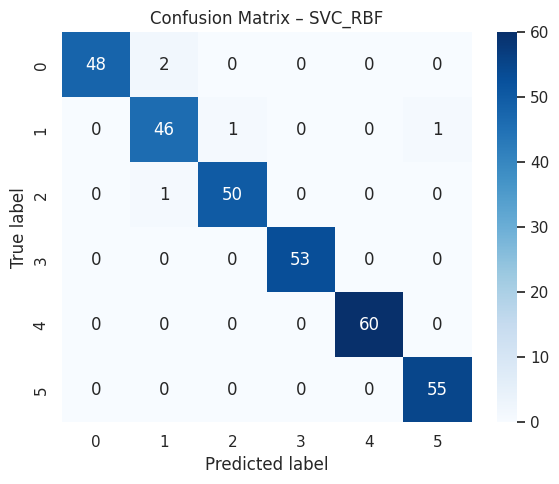

Classification report for best model (SVC_RBF):

              precision    recall  f1-score   support

           0      1.000     0.960     0.980        50
           1      0.939     0.958     0.948        48
           2      0.980     0.980     0.980        51
           3      1.000     1.000     1.000        53
           4      1.000     1.000     1.000        60
           5      0.982     1.000     0.991        55

    accuracy                          0.984       317
   macro avg      0.984     0.983     0.983       317
weighted avg      0.984     0.984     0.984       317



In [79]:
best_model_name = results_df.index[0]
print("Best model by accuracy:", best_model_name)

best_cm = conf_matrices[best_model_name]

plt.figure(figsize=(6, 5))
sns.heatmap(
    best_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=unique_labels,
    yticklabels=unique_labels
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.tight_layout()
plt.show()

print(f"Classification report for best model ({best_model_name}):\n")
print(reports[best_model_name])


### 6.3 How to Interpret the Comparison

When comparing models, consider:

1. **Test Accuracy**  
   Proportion of correctly classified examples on the test set. Higher is better.

2. **Macro F1-score**  
   Average F1-score across classes, giving equal weight to each class.  
   This is particularly informative when some classes have fewer samples.

3. **Weighted F1-score**  
   F1-score averaged over classes, weighted by the number of samples per class.

4. **Confusion Matrix**  
   Reveals *which* classes are confused with each other. Even if two models have similar accuracy, one may perform better on specific gestures that you care about more.

5. **Training Time / Complexity**  
   For deployment, simpler and faster models may be preferable if they achieve similar accuracy.

In many keypoint-based gesture recognition tasks:

- **SVC with RBF kernel** and **Random Forest** often achieve the best trade-off between accuracy and robustness.
- **Logistic Regression** and **Linear SVC** are valuable baselines and are computationally efficient.
- **KNeighbors** is simple and intuitive but can be slower at inference time as the dataset grows.


### 6.4 Cross-validation: Robustness Across Different Splits

So far, we evaluated each model on a single train/test split. To obtain a more robust estimate of performance, we can use **k-fold cross-validation**:

- The dataset is split into *k* folds (here, `k = 5`).
- For each fold, the model is trained on `k-1` folds and evaluated on the remaining fold.
- The scores are then averaged across folds.

This procedure reduces the dependence on a single random split and provides a more stable comparison between models.


In [80]:
from sklearn.model_selection import cross_val_score

cv_results = {}

for name, model in models.items():
    print(f"Running 5-fold cross-validation for: {name}")
    # cross_val_score will clone and refit the model internally for each fold
    scores = cross_val_score(
        model,
        X_dataset,
        y_dataset,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
    )
    cv_results[name] = {
        "cv_accuracy_mean": scores.mean(),
        "cv_accuracy_std": scores.std(),
    }
    print(f"  Mean CV accuracy: {scores.mean():.4f} \u00b1 {scores.std():.4f}")

cv_df = pd.DataFrame(cv_results).T
cv_df

# Merge cross-validation statistics into the existing results DataFrame
results_with_cv = results_df.join(cv_df)
print("Results including 5-fold cross-validation statistics:")
results_with_cv

Running 5-fold cross-validation for: LinearSVC
  Mean CV accuracy: 0.7135 ± 0.0316
Running 5-fold cross-validation for: LogisticRegression
  Mean CV accuracy: 0.7040 ± 0.0377
Running 5-fold cross-validation for: KNeighbors
  Mean CV accuracy: 0.7380 ± 0.0497
Running 5-fold cross-validation for: SVC_RBF
  Mean CV accuracy: 0.8374 ± 0.0636
Running 5-fold cross-validation for: RandomForest
  Mean CV accuracy: 0.8374 ± 0.0767
Results including 5-fold cross-validation statistics:


,accuracy,f1_macro,f1_weighted,train_time_sec,cv_accuracy_mean,cv_accuracy_std
SVC_RBF,0.984227,0.983238,0.984258,0.195418,0.837397,0.063584
RandomForest,0.955836,0.956457,0.956074,2.449397,0.837406,0.076710
KNeighbors,0.943218,0.944148,0.943660,0.003392,0.737954,0.049701
LogisticRegression,0.864353,0.863706,0.863932,0.086621,0.703996,0.037707
LinearSVC,0.851735,0.851008,0.852116,0.057827,0.713489,0.031637


### 6.5 Inference Time and Model Size

For real-time hand gesture recognition, it is not enough for a model to be accurate; it must also be:

- Fast enough to run on each video frame, and  
- Small enough to fit within the memory constraints of the target device.

We therefore compare:

1. **Inference time per sample** on the held-out test set (in milliseconds).  
2. **Model file size** on disk (in kilobytes), using the `.joblib` files saved earlier.


Inference time and model size:
Comprehensive comparison of all models:


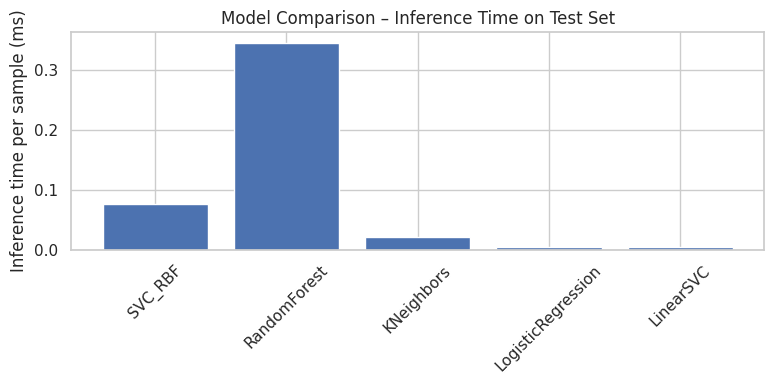

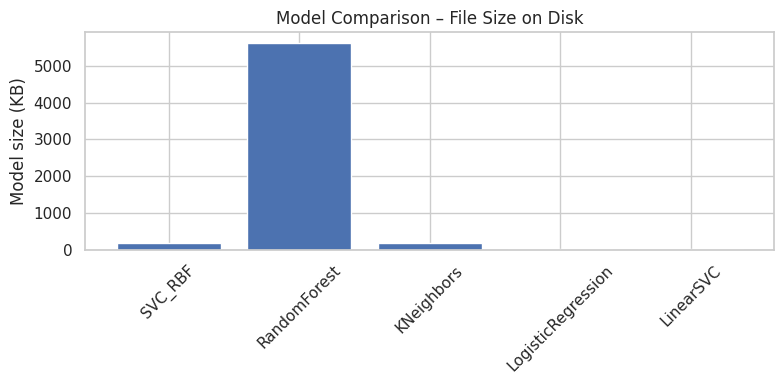

In [81]:
inference_stats = {}

for name in models.keys():
    model_path = f"models/keypoint/keypoint_classifier_{name}_{timestamp}.joblib"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Expected model file not found: {model_path}")

    # Load the model from disk
    loaded_model = joblib.load(model_path)

    # Measure inference time on the entire test set
    start = time.time()
    _ = loaded_model.predict(X_test)
    end = time.time()

    total_time = end - start
    time_per_sample_ms = (total_time / len(X_test)) * 1000.0

    # Measure model size on disk (KB)
    size_bytes = os.path.getsize(model_path)
    size_kb = size_bytes / 1024.0

    inference_stats[name] = {
        "inference_time_ms_per_sample": time_per_sample_ms,
        "model_size_kb": size_kb,
    }

inference_df = pd.DataFrame(inference_stats).T
print("Inference time and model size:")
inference_df

full_comparison_df = results_with_cv.join(inference_df)
print("Comprehensive comparison of all models:")
full_comparison_df

# To visualise the speed and size trade-offs, we can plot the inference time and model size for each model.
plt.figure(figsize=(8, 4))
plt.bar(full_comparison_df.index, full_comparison_df["inference_time_ms_per_sample"])
plt.ylabel("Inference time per sample (ms)")
plt.title("Model Comparison – Inference Time on Test Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(full_comparison_df.index, full_comparison_df["model_size_kb"])
plt.ylabel("Model size (KB)")
plt.title("Model Comparison – File Size on Disk")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 6.6 Per-class F1-score Comparison

Global metrics (overall accuracy, macro F1) summarise performance across all classes, but they can hide important differences:

- Some gestures may be much harder to classify than others.
- Different models may specialise in different subsets of gestures.

To analyse this, we compute the **F1-score for each class and each model**, and visualise the results in a bar chart.


Per-class F1-scores for each model:


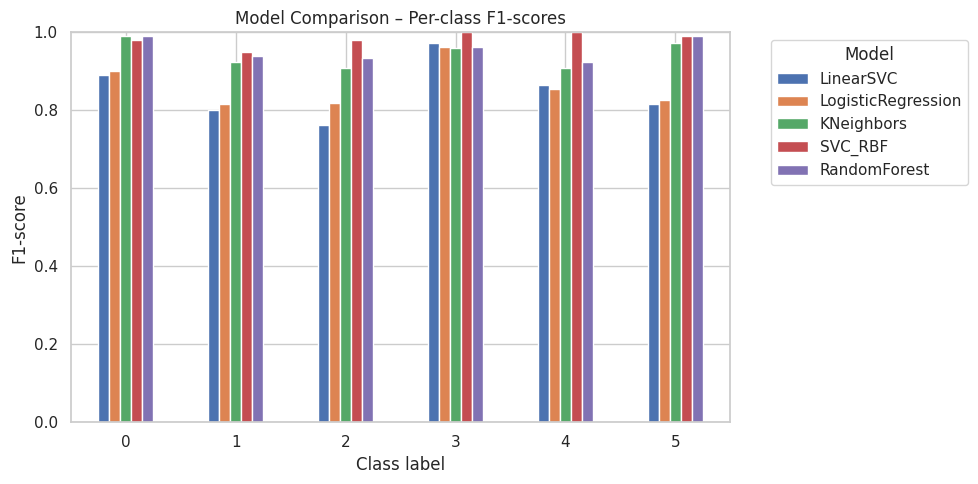

In [82]:
from sklearn.metrics import classification_report

per_class_f1_scores = {}

for model_name, model in models.items():
    # Recompute predictions on the test set
    y_pred = model.predict(X_test)

    # Obtain the classification report as a dictionary
    report_dict = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        zero_division=0,
    )

    # Extract per-class F1-scores (keys that correspond to class labels)
    class_f1s = {}
    for label_str, stats in report_dict.items():
        if label_str.isdigit():
            class_label = int(label_str)
            class_f1s[class_label] = stats["f1-score"]

    per_class_f1_scores[model_name] = class_f1s

# Convert to DataFrame: rows = classes, columns = models
per_class_f1_df = pd.DataFrame(per_class_f1_scores)
per_class_f1_df = per_class_f1_df.sort_index()

print("Per-class F1-scores for each model:")
per_class_f1_df

# We now plot the per-class F1-scores to compare how each model behaves on each gesture class.
ax = per_class_f1_df.plot(kind="bar", figsize=(10, 5))
plt.ylim(0.0, 1.0)
plt.ylabel("F1-score")
plt.xlabel("Class label")
plt.title("Model Comparison – Per-class F1-scores")
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 7. Using and Verifying Saved Models

As a final sanity check, we now **load the saved model files and test it on a real sample from the held-out test set**. This confirms that:

1. The model file can be loaded correctly.
2. The loaded model produces a sensible prediction on real data.
3. The prediction can be compared against the known ground-truth label.


In [83]:
import joblib
import numpy as np
import glob
import os

# Find all saved models using the current timestamp
model_files = glob.glob(f"../models/keypoint/keypoint_classifier_*_{timestamp}.joblib")

print("Models detected for this timestamp:")
for f in model_files:
    print("  -", os.path.basename(f))

print("\nRunning verification on all models...\n")

test_index = 0  # which test sample to check
example_keypoints = X_test[test_index].reshape(1, -1)
true_label = y_test[test_index]

for path in model_files:
    model_name = os.path.basename(path)

    deployed_model = joblib.load(path)
    predicted_class = deployed_model.predict(example_keypoints)[0]

    print("=" * 80)
    print(f"Loaded model: {model_name}")
    print(f"Test sample index: {test_index}")
    print(f"True gesture class:      {true_label}")
    print(f"Predicted gesture class: {predicted_class}")

    if predicted_class == true_label:
        print("Result: prediction matches the true label.")
    else:
        print("Result: prediction does NOT match the true label.")


Models detected for this timestamp:
  - keypoint_classifier_LinearSVC_20251119_095007.joblib
  - keypoint_classifier_LogisticRegression_20251119_095007.joblib
  - keypoint_classifier_SVC_RBF_20251119_095007.joblib
  - keypoint_classifier_RandomForest_20251119_095007.joblib
  - keypoint_classifier_KNeighbors_20251119_095007.joblib

Running verification on all models...

Loaded model: keypoint_classifier_LinearSVC_20251119_095007.joblib
Test sample index: 0
True gesture class:      0
Predicted gesture class: 0
Result: prediction matches the true label.
Loaded model: keypoint_classifier_LogisticRegression_20251119_095007.joblib
Test sample index: 0
True gesture class:      0
Predicted gesture class: 0
Result: prediction matches the true label.
Loaded model: keypoint_classifier_SVC_RBF_20251119_095007.joblib
Test sample index: 0
True gesture class:      0
Predicted gesture class: 0
Result: prediction matches the true label.
Loaded model: keypoint_classifier_RandomForest_20251119_095007.job